# **Classifying Epileptic Events using Deep Learning on Intracranial EEG Data**

### **Introduction:**

Epilepsy is a neurological disorder characterized by recurrent seizures, and predicting these events can significantly improve patient care. This project, **DeepEEG**, uses **deep learning** techniques to classify epileptic events from **intracranial EEG** (Electroencephalography). 

Event Epoch Features (EEF): The reshaped features related to specific event types and frequency bands, which are crucial for event-related brain activity analysis.

By processing and analyzing the EEG data, the goal is to identify patterns associated with specific epileptic events, such as seizures, and categorize them into different trigger events. Using **deep neural networks**, the model learns to recognize these patterns and make accurate predictions. Hyperparameter optimization helps fine-tune the model for better performance, and evaluation metrics such as **accuracy**, **precision**, **recall**, and **F1 score** are used to assess its effectiveness.

This project aims to provide a tool that can potentially assist in **early epilepsy detection** and **event prediction**, improving the management and treatment of epilepsy patients.



In [5]:
pip install --quiet mne-connectivity

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.2/115.2 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 94.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install --quiet optuna-integration

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 4.0 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --quiet optuna-integration

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install --quiet --upgrade torch

Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install --quiet tensorpac

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.6/423.6 kB 16.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [11]:
pip install --quiet pytorch-ranger

Note: you may need to restart the kernel to use updated packages.


### **Importing Libraries**

In [9]:
import os
from pathlib import Path
import pywt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import mne
from mne.io import Raw
from mne import Epochs, find_events, pick_types
from mne.filter import filter_data
from mne.time_frequency import psd_array_welch
from mne_connectivity import spectral_connectivity_epochs
from tensorpac import Pac

# Set log-level to reduce verbosity
mne.set_log_level("WARNING")

### **Loading Sample Data**

In [13]:
from pathlib import Path
import mne

def load_epochs(subject_id, save_dir="/kaggle/input/processed-epochs/processed_epochs", file_filter="*_processed-epo.fif"):
    """
    Load epochs for a given subject, ensuring all sessions have a consistent channel structure 
    without filling missing channels with zeros.

    Parameters:
    - subject_id (str): Subject identifier (e.g., "sub-01").
    - save_dir (str): Directory where processed epochs are stored.
    - file_filter (str): Pattern to match specific `.fif` files.

    Returns:
    - epochs_list (list of mne.Epochs): List of epochs objects with unified channels.
    """
    subject_path = Path(save_dir) / subject_id
    if not subject_path.exists():
        raise FileNotFoundError(f"Directory for {subject_id} not found in {save_dir}!")

    fif_files = sorted(subject_path.glob(file_filter))
    if not fif_files:
        raise FileNotFoundError(f"No `.fif` files found for {subject_id} in {subject_path}.")

    epochs_list = []
    all_channels = set()

    # Load all epochs and collect all unique channel names
    for f in fif_files:
        try:
            epochs = mne.read_epochs(f, preload=True)
            print(f"Loaded: {f.name} | {len(epochs)} epochs | {epochs.info['nchan']} channels")
            epochs_list.append(epochs)
            all_channels.update(epochs.ch_names)  # Collect unique channels
        except Exception as e:
            print(f"Error loading {f.name}: {e}")

    if not epochs_list:
        raise ValueError("No epochs loaded. Check files and filters.")

    all_channels = sorted(all_channels)  # Sort for consistency
    print(f"ℹ️ Total unique channels across sessions: {len(all_channels)}")

    # Ensure all epochs have a consistent channel order without filling missing ones
    for i, epochs in enumerate(epochs_list):
        existing_channels = epochs.ch_names
        missing_channels = list(set(all_channels) - set(existing_channels))
        
        if missing_channels:
            print(f"⚠️ {fif_files[i].name}: {len(missing_channels)} channels missing (not filled)")
        
        # Pick channels that are available without adding new ones
        common_channels = [ch for ch in all_channels if ch in existing_channels]
        epochs_list[i] = epochs.pick_channels(common_channels, ordered=True)

    print(f"✅ Successfully loaded {len(epochs_list)} epochs objects with a consistent channel structure.")
    
    return epochs_list


In [14]:
epochs = load_epochs("sub-01")  

Loaded: sub-01_ses-01_task-auditory_run-01_ieeg_processed-epo.fif | 183 epochs | 66 channels
Loaded: sub-01_ses-02_task-auditory_run-01_ieeg_processed-epo.fif | 183 epochs | 11 channels
Loaded: sub-01_ses-03_task-auditory_run-01_ieeg_processed-epo.fif | 183 epochs | 58 channels
ℹ️ Total unique channels across sessions: 131
⚠️ sub-01_ses-01_task-auditory_run-01_ieeg_processed-epo.fif: 65 channels missing (not filled)
⚠️ sub-01_ses-02_task-auditory_run-01_ieeg_processed-epo.fif: 120 channels missing (not filled)
⚠️ sub-01_ses-03_task-auditory_run-01_ieeg_processed-epo.fif: 73 channels missing (not filled)
✅ Successfully loaded 3 epochs objects with a consistent channel structure.


In [15]:
# Selecting a Specific Session (Since epochs is a list, you can access a specific session using indexing)

epochs_ses_1 = epochs[0]  # First session (ses-01)
epochs_ses_2 = epochs[1]  # Second session (ses-02)
epochs_ses_3 = epochs[2]  # Third session (ses-03)


In [16]:
epochs_ses_1

<EpochsFIF | 183 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~64.7 MiB, data loaded,
 'Trigger-401': 61
 'Trigger-402': 61
 'Trigger-501': 61>

In [17]:
print("===== SESSION 1 DETAILS =====")

# Print metadata summary
print("\n--- Metadata Info ---")
print(epochs_ses_1.info)

# Print event ID mapping
print("\n--- Event ID Mapping ---")
print(epochs_ses_1.event_id)

# Print channel names
print("\n--- Channel Names ---")
print(epochs_ses_1.ch_names)

# Print shape of the epochs data
print("\n--- Epochs Data Shape ---")
print(epochs_ses_1.get_data().shape)


===== SESSION 1 DETAILS =====

--- Metadata Info ---
<Info | 10 non-empty values
 bads: []
 ch_names: POL A1-A2, POL A10-A11, POL A11-A12, POL A12-A13, POL A13-A14, ...
 chs: 66 EEG
 custom_ref_applied: False
 file_id: 4 items (dict)
 highpass: 0.1 Hz
 lowpass: 150.0 Hz
 meas_date: 2000-01-01 00:00:00 UTC
 meas_id: 4 items (dict)
 nchan: 66
 projs: []
 sfreq: 1000.0 Hz
 subject_info: <subject_info | his_id: 0, last_name: Name, first_name: No, birthday: 1800-01-01, sex: 2>
>

--- Event ID Mapping ---
{'Trigger-401': 1, 'Trigger-402': 2, 'Trigger-501': 3}

--- Channel Names ---
['POL A1-A2', 'POL A10-A11', 'POL A11-A12', 'POL A12-A13', 'POL A13-A14', 'POL A14-A15', 'POL A15-A16', 'POL A17-A18', 'POL A18-A19', 'POL A19-A20', 'POL A2-A3', 'POL A20-A21', 'POL A21-A22', 'POL A22-A23', 'POL A23-A24', 'POL A25-A26', 'POL A25-A33', 'POL A26-A27', 'POL A26-A34', 'POL A27-A28', 'POL A27-A35', 'POL A28-A29', 'POL A28-A36', 'POL A29-A30', 'POL A29-A37', 'POL A3-A4', 'POL A30-A31', 'POL A30-A38', 'P

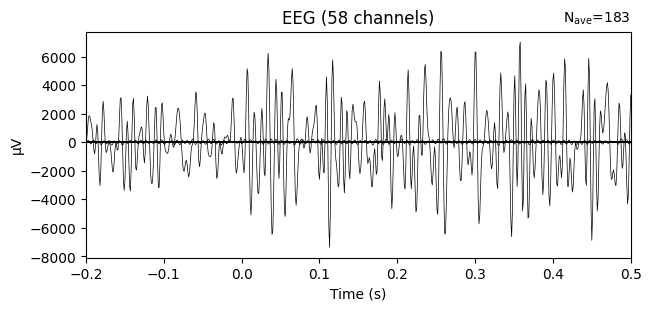

In [18]:
epochs_ses_3.average().plot();



<ipython-input-19-5c7dde3d415c>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  epochs_ses_1.plot_psd();


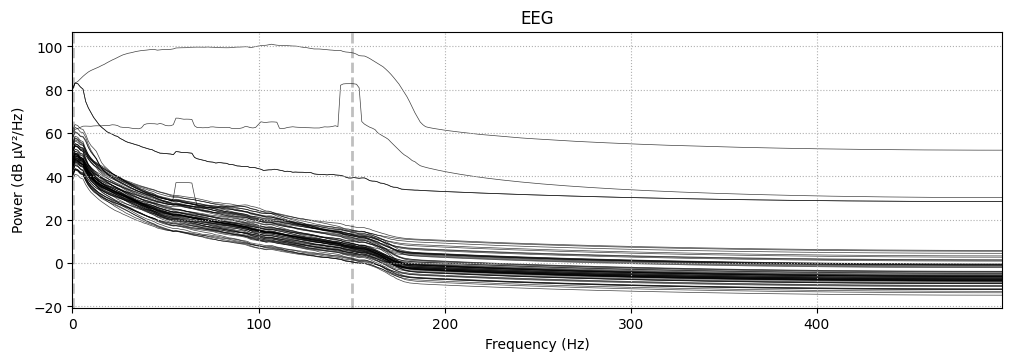

In [19]:
epochs_ses_1.plot_psd();


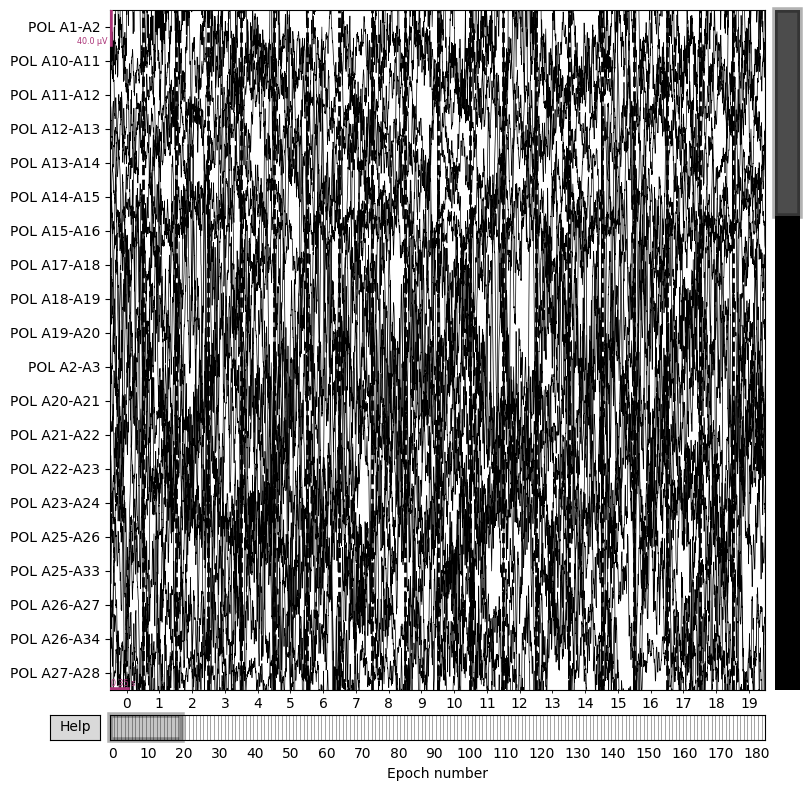

In [20]:
epochs_ses_1.plot();


In [21]:
# Extracting Events
def get_events_from_epochs(epochs):
    """
    Retrieve events and event IDs from an mne.Epochs object.
    
    Parameters:
    - epochs: An mne.Epochs object.
    
    Returns:
    - events: The events array (shape: n_events x 3).
    - event_id: A dictionary mapping event names to event IDs.
    """
    events = epochs.events  # Shape: (n_events, 3)
    event_id = epochs.event_id  # Dictionary: {event_name: event_code}
    return events, event_id

# Retrieve events for each epochs file
for i, epochs in enumerate(epochs):
    print(f"File {i + 1}:")
    events, event_id = get_events_from_epochs(epochs)
    print(f"  Events shape: {events.shape}")
    print(f"  Event IDs: {event_id}")



File 1:
  Events shape: (183, 3)
  Event IDs: {'Trigger-401': 1, 'Trigger-402': 2, 'Trigger-501': 3}
File 2:
  Events shape: (183, 3)
  Event IDs: {'Trigger-401': 1, 'Trigger-402': 2, 'Trigger-501': 3}
File 3:
  Events shape: (183, 3)
  Event IDs: {'Trigger-401': 1, 'Trigger-402': 2, 'Trigger-501': 3}


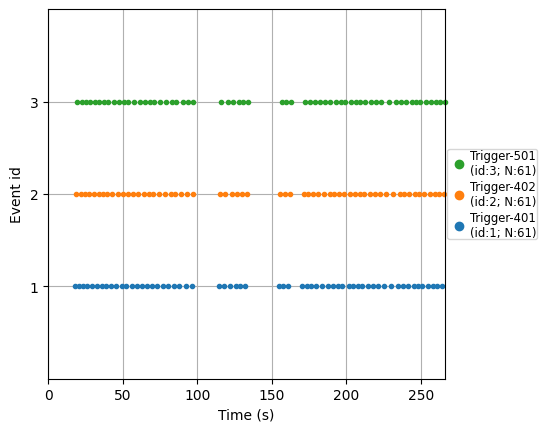

In [22]:
# Visualize events 
event_conditions = ['Trigger-401', 'Trigger-402', 'Trigger-501']  # Example event conditions

event1 = 'Trigger-401'
event2 = 'Trigger-402'
event3 = 'Trigger-501'

sfreq = epochs.info['sfreq']


fig = mne.viz.plot_events(events, sfreq=sfreq, event_id=event_id);

### **Compute connectivity**

In [23]:
from mne_connectivity import spectral_connectivity_epochs
from itertools import combinations


def compute_connectivity_per_session(epochs_list, bands, subject_id):
    """
    Compute spectral connectivity for each session, preserving events and epochs.
    
    For each session (an mne.Epochs object):
      1. Checks if there are at least 2 channels (since connectivity requires pairs).
      2. Retrieves events and event IDs.
      3. Identifies unique event codes and maps them to their event names.
      4. Generates channel pairs using combinations.
      5. Computes connectivity for each event and each frequency band.
      6. Stores results in a DataFrame.
    
    Parameters:
      - epochs_list: List of mne.Epochs objects, one per session.
      - bands: Dictionary mapping band names to frequency ranges, e.g., {"alpha": (8, 12), "beta": (13, 30)}.
      - subject_id: A string identifier for the subject (e.g., "sub-01").
    
    Returns:
      - session_dfs: A dictionary where keys are session IDs (e.g., "ses-01") and values are DataFrames
                     containing the connectivity data.
    """
    session_dfs = {}

    for session_idx, epochs in enumerate(epochs_list):
        session_id = f"ses-{session_idx+1:02d}"
        ch_names = epochs.ch_names

        if len(ch_names) < 2:
            print(f"⚠️ Skipping {session_id} (insufficient channels)")
            continue

        print(f"\n🔹 Processing {subject_id}, {session_id} ({len(ch_names)} channels)")

        # Retrieve events and event IDs
        events_array, event_id = get_events_from_epochs(epochs)
        print(f"   - Events shape: {events_array.shape}")
        print(f"   - Event IDs: {event_id}")

        # Extract event codes (third column of events_array) and find unique ones.
        event_codes = events_array[:, 2]
        unique_event_codes = np.unique(event_codes)
        print(f"   - Found {len(unique_event_codes)} unique event codes: {unique_event_codes}")

        # Generate all possible unique channel pairs.
        valid_pairs = list(combinations(range(len(ch_names)), 2))
        indices = tuple(np.array(valid_pairs).T)
        pair_names = [f"{ch_names[i]}-{ch_names[j]}" for i, j in valid_pairs]

        session_data = []

        # Process each unique event code.
        for code in unique_event_codes:
            # Map the event code to an event name.
            event_name = None
            for name, event_code in event_id.items():
                if event_code == code:
                    event_name = name
                    break
            
            if event_name is None:
                print(f"⚠️ No matching event name found for event code {code} in {session_id}")
                continue

            # Extract epochs corresponding to this event.
            event_epochs = epochs[event_name]
            if len(event_epochs) == 0:
                print(f"⚠️ No epochs for event {event_name} in {session_id}")
                continue

            conn_results = {}
            # Compute connectivity for each frequency band.
            for band_name, (fmin, fmax) in bands.items():
                conn = spectral_connectivity_epochs(
                    event_epochs,
                    method='wpli2_debiased',
                    mode='multitaper',
                    sfreq=event_epochs.info['sfreq'],
                    fmin=fmin,
                    fmax=fmax,
                    faverage=True,
                    indices=indices
                )
                # Get the connectivity data and remove unnecessary dimensions.
                # Note: if there's only one epoch, squeezing can make the array 1D.
                data = conn.get_data().squeeze()
                conn_results[band_name] = data

            # For each epoch, build a row with connectivity values.
            for epoch_idx in range(len(event_epochs)):
                row = {
                    "subject": subject_id,
                    "session": session_id,
                    "event": event_name,
                    "epoch": epoch_idx
                }
                for band_name, data in conn_results.items():
                    for pair_idx, pair_name in enumerate(pair_names):
                        # Check if the data array is 1-dimensional.
                        # Math analogy: If you have only one row, your "matrix" is actually a vector.
                        if data.ndim == 1:
                            # If one epoch exists, we access the value directly.
                            value = data[pair_idx]
                        else:
                            # For multiple epochs, index using [epoch_idx, pair_idx]
                            value = data[epoch_idx, pair_idx]
                        row[f"{pair_name}_{band_name}"] = value
                session_data.append(row)

        # Combine all rows into a DataFrame for this session.
        session_df = pd.DataFrame(session_data)
        session_dfs[session_id] = session_df

    return session_dfs


In [24]:
bands = {
    "Alpha": (8, 12),
    "Beta": (12, 30),
    "Gamma": (30, 50)
}

# Load your epochs (replace with your actual data loading)
epochs_list = load_epochs("sub-01")  
subject_id = "sub-01"

# Compute connectivity
session_dfs = compute_connectivity_per_session(epochs_list, bands, "sub-01")

# Save DataFrames
for session_id, df in session_dfs.items():
    filename = f"{subject_id}_{session_id}_connectivity.csv"
    df.to_csv(filename, index=False)
    print(f"✅ Saved {filename}")

Loaded: sub-01_ses-01_task-auditory_run-01_ieeg_processed-epo.fif | 183 epochs | 66 channels
Loaded: sub-01_ses-02_task-auditory_run-01_ieeg_processed-epo.fif | 183 epochs | 11 channels
Loaded: sub-01_ses-03_task-auditory_run-01_ieeg_processed-epo.fif | 183 epochs | 58 channels
ℹ️ Total unique channels across sessions: 131
⚠️ sub-01_ses-01_task-auditory_run-01_ieeg_processed-epo.fif: 65 channels missing (not filled)
⚠️ sub-01_ses-02_task-auditory_run-01_ieeg_processed-epo.fif: 120 channels missing (not filled)
⚠️ sub-01_ses-03_task-auditory_run-01_ieeg_processed-epo.fif: 73 channels missing (not filled)
✅ Successfully loaded 3 epochs objects with a consistent channel structure.

🔹 Processing sub-01, ses-01 (66 channels)
   - Events shape: (183, 3)
   - Event IDs: {'Trigger-401': 1, 'Trigger-402': 2, 'Trigger-501': 3}
   - Found 3 unique event codes: [1 2 3]

🔹 Processing sub-01, ses-02 (11 channels)
   - Events shape: (183, 3)
   - Event IDs: {'Trigger-401': 1, 'Trigger-402': 2, 'Trigg

In [25]:
# Concatenate all DataFrames in session_dfs.values() into one DataFrame
full_df = pd.concat(session_dfs.values(), ignore_index=True)

full_df = full_df.dropna(axis=1, how="any")


# Now you have a single DataFrame containing all connectivity data across sessions
full_df.head()  # Optional: Print the first few rows to verify


,subject,session,event,epoch,POL DC01-POL DC02_Alpha,POL DC01-POL DC02_Beta,POL DC01-POL DC02_Gamma
0,sub-01,ses-01,Trigger-401,0,-0.068598,0.03942,0.00723
1,sub-01,ses-01,Trigger-401,1,-0.068598,0.03942,0.00723
2,sub-01,ses-01,Trigger-401,2,-0.068598,0.03942,0.00723
3,sub-01,ses-01,Trigger-401,3,-0.068598,0.03942,0.00723
4,sub-01,ses-01,Trigger-401,4,-0.068598,0.03942,0.00723


In [26]:
# Example: Load a single CSV file
filename = "sub-01_ses-01_connectivity.csv"
df = pd.read_csv(filename)

# Display the first few rows
df.head()

,subject,session,event,epoch,POL A1-A2-POL A10-A11_Alpha,POL A1-A2-POL A11-A12_Alpha,POL A1-A2-POL A12-A13_Alpha,POL A1-A2-POL A13-A14_Alpha,POL A1-A2-POL A14-A15_Alpha,POL A1-A2-POL A15-A16_Alpha,...,POL A6-A7-POL A7-A8_Gamma,POL A6-A7-POL A9-A10_Gamma,POL A6-A7-POL DC01_Gamma,POL A6-A7-POL DC02_Gamma,POL A7-A8-POL A9-A10_Gamma,POL A7-A8-POL DC01_Gamma,POL A7-A8-POL DC02_Gamma,POL A9-A10-POL DC01_Gamma,POL A9-A10-POL DC02_Gamma,POL DC01-POL DC02_Gamma
0,sub-01,ses-01,Trigger-401,0,-0.010813,0.039986,-0.002295,-0.020968,0.028079,-0.012217,...,-0.009815,0.003614,-0.020073,0.066786,0.001261,0.00537,0.011194,-0.024309,-0.016614,0.00723
1,sub-01,ses-01,Trigger-401,1,-0.010813,0.039986,-0.002295,-0.020968,0.028079,-0.012217,...,-0.009815,0.003614,-0.020073,0.066786,0.001261,0.00537,0.011194,-0.024309,-0.016614,0.00723
2,sub-01,ses-01,Trigger-401,2,-0.010813,0.039986,-0.002295,-0.020968,0.028079,-0.012217,...,-0.009815,0.003614,-0.020073,0.066786,0.001261,0.00537,0.011194,-0.024309,-0.016614,0.00723
3,sub-01,ses-01,Trigger-401,3,-0.010813,0.039986,-0.002295,-0.020968,0.028079,-0.012217,...,-0.009815,0.003614,-0.020073,0.066786,0.001261,0.00537,0.011194,-0.024309,-0.016614,0.00723
4,sub-01,ses-01,Trigger-401,4,-0.010813,0.039986,-0.002295,-0.020968,0.028079,-0.012217,...,-0.009815,0.003614,-0.020073,0.066786,0.001261,0.00537,0.011194,-0.024309,-0.016614,0.00723


In [27]:
# Example: Load a single CSV file
filename = "sub-01_ses-02_connectivity.csv"
df = pd.read_csv(filename)

df.head()

,subject,session,event,epoch,POL A40-A48-POL A41-A49_Alpha,POL A40-A48-POL A42-A50_Alpha,POL A40-A48-POL A43-A51_Alpha,POL A40-A48-POL A44-A52_Alpha,POL A40-A48-POL A45-A53_Alpha,POL A40-A48-POL A46-A54_Alpha,...,POL A46-A54-POL A47-A55_Gamma,POL A46-A54-POL A48-A56_Gamma,POL A46-A54-POL DC01_Gamma,POL A46-A54-POL DC02_Gamma,POL A47-A55-POL A48-A56_Gamma,POL A47-A55-POL DC01_Gamma,POL A47-A55-POL DC02_Gamma,POL A48-A56-POL DC01_Gamma,POL A48-A56-POL DC02_Gamma,POL DC01-POL DC02_Gamma
0,sub-01,ses-02,Trigger-401,0,0.068928,-0.010524,0.011754,0.007979,0.033091,0.009325,...,-0.006457,0.001868,-0.016382,0.001972,-0.01592,0.02042,0.039227,-0.017349,0.010172,0.00723
1,sub-01,ses-02,Trigger-401,1,0.068928,-0.010524,0.011754,0.007979,0.033091,0.009325,...,-0.006457,0.001868,-0.016382,0.001972,-0.01592,0.02042,0.039227,-0.017349,0.010172,0.00723
2,sub-01,ses-02,Trigger-401,2,0.068928,-0.010524,0.011754,0.007979,0.033091,0.009325,...,-0.006457,0.001868,-0.016382,0.001972,-0.01592,0.02042,0.039227,-0.017349,0.010172,0.00723
3,sub-01,ses-02,Trigger-401,3,0.068928,-0.010524,0.011754,0.007979,0.033091,0.009325,...,-0.006457,0.001868,-0.016382,0.001972,-0.01592,0.02042,0.039227,-0.017349,0.010172,0.00723
4,sub-01,ses-02,Trigger-401,4,0.068928,-0.010524,0.011754,0.007979,0.033091,0.009325,...,-0.006457,0.001868,-0.016382,0.001972,-0.01592,0.02042,0.039227,-0.017349,0.010172,0.00723


### **Machine Learning**

In [29]:
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from mne.decoding import SlidingEstimator, cross_val_multiscore

In [30]:
# Define the event conditions you want to label
event_conditions = ['Trigger-401', 'Trigger-402', 'Trigger-501'] 

#To keep chance level at 50% accuracy, we first equalize the number of epochs in each condition.
epochs.equalize_event_counts(event_id)

# Separate auditory and visual epochs
Trigger1_epochs = epochs['Trigger-401']
Trigger2_epochs = epochs['Trigger-402']

# Print information about the equalized epochs
print(Trigger1_epochs)
print(Trigger2_epochs)

<EpochsFIF | 61 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~19.0 MiB, data loaded,
 'Trigger-401': 61>
<EpochsFIF | 61 events (all good), -0.2 – 0.5 s (baseline -0.2 – 0 s), ~19.0 MiB, data loaded,
 'Trigger-402': 61>


In [31]:
full_df.columns

Index(['subject', 'session', 'event', 'epoch', 'POL A40-A48-POL A41-A49_Alpha',
       'POL A40-A48-POL A42-A50_Alpha', 'POL A40-A48-POL A43-A51_Alpha',
       'POL A40-A48-POL A44-A52_Alpha', 'POL A40-A48-POL A45-A53_Alpha',
       'POL A40-A48-POL A46-A54_Alpha',
       ...
       'POL A46-A54-POL A47-A55_Gamma', 'POL A46-A54-POL A48-A56_Gamma',
       'POL A46-A54-POL DC01_Gamma', 'POL A46-A54-POL DC02_Gamma',
       'POL A47-A55-POL A48-A56_Gamma', 'POL A47-A55-POL DC01_Gamma',
       'POL A47-A55-POL DC02_Gamma', 'POL A48-A56-POL DC01_Gamma',
       'POL A48-A56-POL DC02_Gamma', 'POL DC01-POL DC02_Gamma'],
      dtype='object', length=169)

In [32]:
print("Original labels:", full_df['event'].unique())

Original labels: ['Trigger-401' 'Trigger-402' 'Trigger-501']


In [33]:
# Define mapping dictionary
remap_dict = {'Trigger-401': 0, 'Trigger-402': 1, 'Trigger-501': 2}

# Apply mapping to convert event labels to integers
full_df['event'] = full_df['event'].map(remap_dict).astype(int)


In [34]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Select only columns that contain channel-related names (e.g., contain "POL")
channel_features = [col for col in full_df.columns if "POL" in col]

# Keep only these columns
X = full_df[channel_features]  
y = full_df['event']  # Labels


# Step 1: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [35]:

# Step 2: Define the best hyperparameters based on grid search results
best_params = {
    'colsample_bytree': 0.8,
    'learning_rate': 0.1,
    'max_depth': 3,
    'n_estimators': 100,
    'subsample': 0.8
}

# Step 3: Set up the XGBoost classifier with the best hyperparameters
xgb = XGBClassifier( 
    eval_metric='mlogloss',
    **best_params  # Apply the best hyperparameters here
)

# Step 4: Fit the XGBoost model on the training data
xgb.fit(X_train, y_train)

# Step 5: Make predictions on the test data
y_pred = xgb.predict(X_test)

# Step 6: Evaluate the model performance using accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with best hyperparameters: {accuracy:.4f}")


Accuracy with best hyperparameters: 1.0000


In [36]:
train_accuracy = accuracy_score(y_train, xgb.predict(X_train))
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")


Training Accuracy: 1.0000
Test Accuracy: 1.0000


In [37]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Predictions
y_pred = xgb.predict(X_test)
y_pred_probs = xgb.predict_proba(X_test)  # For AUC-ROC

# Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')  # Macro for multi-class
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# AUC-ROC for multi-class (One-vs-Rest)
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')

# Print classification report (detailed per class)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Print overall metrics
print(f"\nOverall Test Results:\n"
      f"Accuracy: {accuracy:.4f}\n"
      f"AUC-ROC: {roc_auc:.4f}\n"
      f"Precision (Macro): {precision:.4f}\n"
      f"Recall (Macro): {recall:.4f}\n"
      f"F1 Score (Macro): {f1:.4f}")



Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       1.00      1.00      1.00        37
           2       1.00      1.00      1.00        37

    accuracy                           1.00       110
   macro avg       1.00      1.00      1.00       110
weighted avg       1.00      1.00      1.00       110


Overall Test Results:
Accuracy: 1.0000
AUC-ROC: 1.0000
Precision (Macro): 1.0000
Recall (Macro): 1.0000
F1 Score (Macro): 1.0000


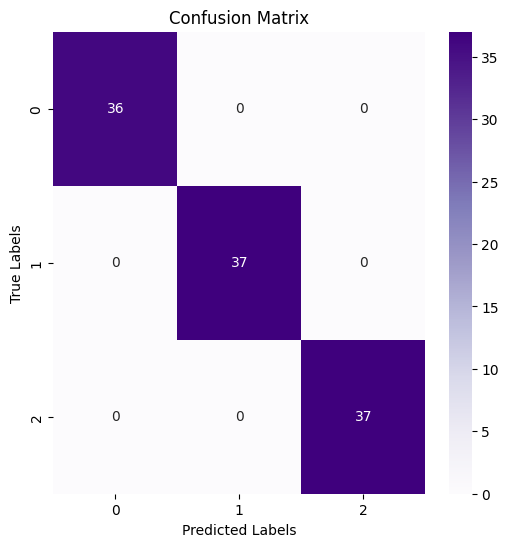

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()


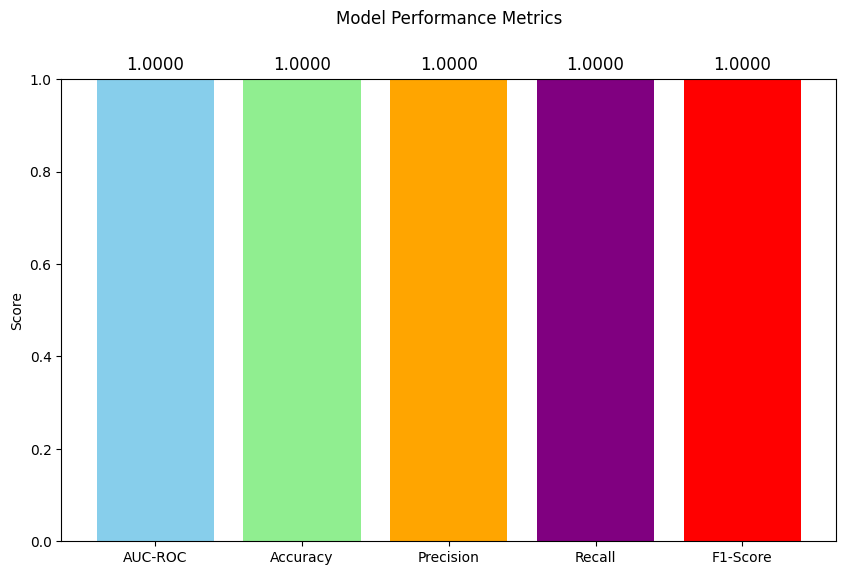

In [39]:
# Metrics Dictionary
metrics = {'AUC-ROC': roc_auc, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1}
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Plot Metrics Bar Chart
plt.figure(figsize=(10, 6))
plt.bar(metric_names, metric_values, color=['skyblue', 'lightgreen', 'orange', 'purple', 'red'])
plt.title("Model Performance Metrics", pad=40)
plt.ylabel("Score")
plt.ylim(0, 1)  # All scores are between [0, 1]

# Add value annotations
for i, v in enumerate(metric_values):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=12)

plt.show()


In [40]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")


Cross-validation accuracy: 1.0000 ± 0.0000


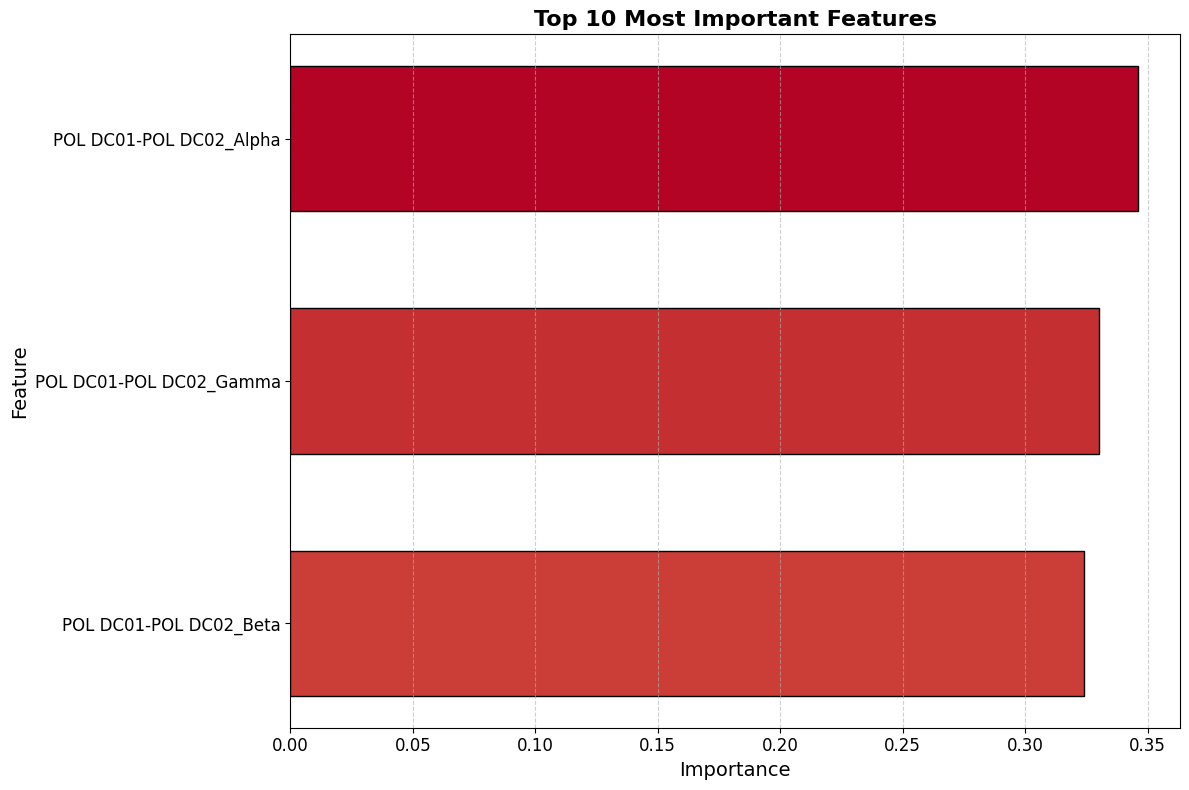

,feature,importance
0,POL DC01-POL DC02_Alpha,0.345899
2,POL DC01-POL DC02_Gamma,0.329970
1,POL DC01-POL DC02_Beta,0.324131


In [41]:
# Get feature importance from the trained model
importances = xgb.feature_importances_

# Step 10: Create a DataFrame of feature importances (with channel-timepoint as the feature names)
feature_importances_df = pd.DataFrame({
    'feature': X.columns,
    'importance': importances
})

# Sort the DataFrame by importance
feature_importances_df = feature_importances_df.sort_values(by='importance', ascending=False)

# Step 11: Visualize the top 10 most important features
top_10_features = feature_importances_df.head(10)

# Set up the plot
plt.figure(figsize=(12, 8))

# Create a color palette based on importance values (from light to dark)
bar_colors = sns.color_palette("coolwarm", as_cmap=True)

# Create the horizontal bar plot
bars = plt.barh(top_10_features['feature'], top_10_features['importance'], 
                color=bar_colors(top_10_features['importance'] / max(top_10_features['importance'])), 
                edgecolor='black', height=0.6)


# Make the title and labels more readable
plt.title('Top 10 Most Important Features', fontsize=16, fontweight='bold')
plt.xlabel('Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)

# Invert the y-axis to display the most important feature at the top
plt.gca().invert_yaxis()

# Customize the grid
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Customize ticks
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

# Step 12: Optionally, output the top important features for further analysis
top_10_features


### **Deep Learning**

In [49]:
import torch
import optuna
import torch.nn as nn
import torch.optim as optim
from pytorch_ranger import Ranger
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
from optuna.integration import PyTorchLightningPruningCallback

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [50]:
# Constants
BATCH_SIZE = 250
TEST_SIZE = 0.25
RANDOM_STATE = 42

# Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE, 
    stratify=y
)

# Normalize the data using StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)  # Fit and transform on training data
x_test_scaled = scaler.transform(x_test)          # Transform test data

# Convert data to PyTorch tensors
# If y_train or y_test are pandas Series, we convert them to numpy arrays using .values
x_train = torch.tensor(x_train_scaled, dtype=torch.float32, device=device)
x_test = torch.tensor(x_test_scaled, dtype=torch.float32, device=device)
y_train = torch.tensor(y_train.values if hasattr(y_train, 'values') else y_train, dtype=torch.long, device=device)
y_test = torch.tensor(y_test.values if hasattr(y_test, 'values') else y_test, dtype=torch.long, device=device)

# DataLoader creation
train_dataset = TensorDataset(x_train, y_train)
test_dataset = TensorDataset(x_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)


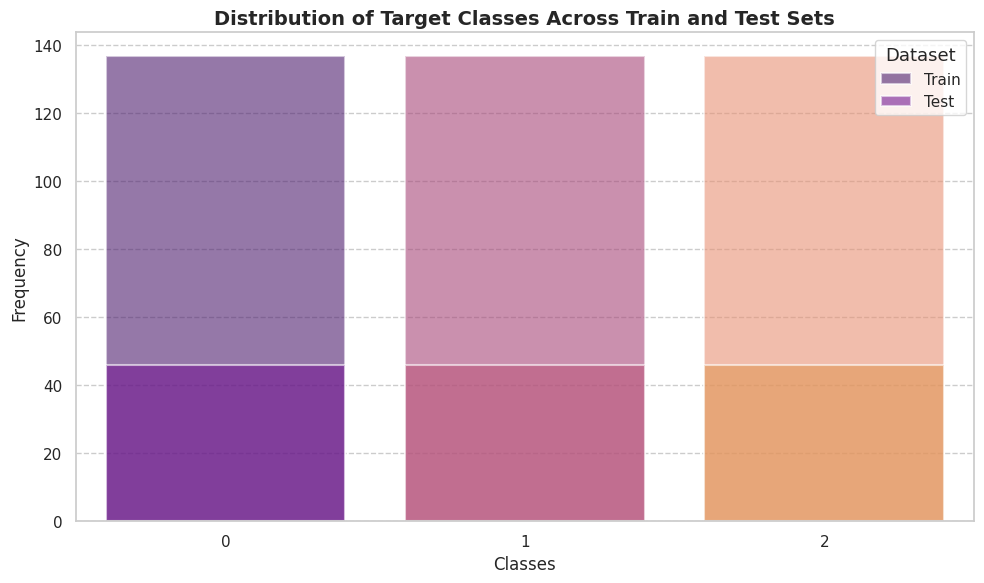

Training size: 411 Test size: 138


In [51]:
# Assuming 'y_train' and 'y_test' are categorical variables with 3 classes (e.g., 0, 1, 2)
# Convert tensors to NumPy arrays by first moving them to CPU
y_train_cpu = y_train.cpu().numpy()
y_test_cpu = y_test.cpu().numpy()

# Set the style of the plot
sns.set(style="whitegrid", palette="viridis", rc={"axes.grid": True, "grid.linestyle": "--"})

# Create a figure and axes for the plot
plt.figure(figsize=(10, 6))

# Plot bar plots for class distributions
sns.countplot(x=y_train_cpu, label='Train', alpha=0.6, linewidth=1.5, palette="magma")
sns.countplot(x=y_test_cpu, label='Test', alpha=0.6, linewidth=1.5, palette="plasma")

# Add labels, title, and legend
plt.xlabel('Classes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Target Classes Across Train and Test Sets', fontsize=14, weight='bold')
plt.legend(title="Dataset", title_fontsize='13', fontsize='11')

# Adjust layout for better appearance
plt.tight_layout()

# Display the plot
plt.show()

# Print the size of the training and test sets
print('Training size:', len(x_train), 'Test size:', len(x_test))


In [52]:
# Define the Mish Function
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(torch.nn.functional.softplus(x))


# Define the Classification Model
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate, weight_init, num_classes=2):
        super(ClassificationModel, self).__init__()
        layers = []
        last_dim = input_dim

        # Hidden layers
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            
            # Activation function
            layers.append(nn.Mish()) #layers.append(nn.ReLU())
            
            
            layers.append(nn.Dropout(dropout_rate))
            last_dim = hidden_dim

        # Output layer (multi-class classification)
        layers.append(nn.Linear(last_dim, num_classes))
        
        # Combine layers into a sequential model
        self.network = nn.Sequential(*layers)

        # Apply weight initialization
        self.apply(weight_init)

    def forward(self, x):
        return self.network(x)

# Define weight initialization strategy
def weight_init(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)


In [54]:
# Constants for training
MAX_EPOCHS = 1000
NUM_CLASSES = len(np.unique(y))  # Assuming y is your labels array/Series
DEVICE = device  # Using the device defined earlier

# Define your ClassificationModel
class ClassificationModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate, weight_init, num_classes):
        super(ClassificationModel, self).__init__()
        layers = []
        last_dim = input_dim
        
        # Build hidden layers
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = hidden_dim
        
        # Final layer maps to the number of classes
        layers.append(nn.Linear(last_dim, num_classes))
        self.network = nn.Sequential(*layers)
        
        # Optionally apply a custom weight initialization
        if weight_init is not None:
            self.network.apply(weight_init)
    
    def forward(self, x):
        return self.network(x)

# Example Ranger optimizer import or definition (if not defined, replace with another optimizer)
# from ranger import Ranger

# Objective Function for Optuna
def objective(trial):
    # Suggest hyperparameters
    # Here the hidden_layers are suggested as a string. We convert that string into a list of integers.
    hidden_layers_str = trial.suggest_categorical('hidden_layers', ['256,128', '512,256,128', '512,256'])
    hidden_layers = [int(x) for x in hidden_layers_str.split(',')]
    
    dropout_rate = trial.suggest_float('dropout_rate', 0.01, 0.3)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)  # Learning rate
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical('batch_size', [32, 64, 128])
    patience = trial.suggest_int('patience', 20, 25)
    clip_grad = trial.suggest_float('clip_grad', 0.5, 5.0)

    # Model initialization (make sure x_train is defined from your preprocessing)
    model = ClassificationModel(
        input_dim=x_train.shape[1],
        hidden_layers=hidden_layers,
        dropout_rate=dropout_rate,
        weight_init=weight_init,  # Set to None if you don't have a custom initializer
        num_classes=NUM_CLASSES
    ).to(DEVICE)

    # Initialize the optimizer. Replace Ranger with your optimizer of choice.
    optimizer = Ranger(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)
    
    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Create DataLoaders with the current batch_size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    best_loss = float('inf')
    no_improvement = 0

    # Training Loop with Early Stopping
    for epoch in range(MAX_EPOCHS):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Handle potential NaN loss
            if not torch.isfinite(loss).all():
                return float('nan')

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip_grad)
            optimizer.step()

            running_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                val_loss += criterion(outputs, labels).item()

        val_loss /= len(test_loader)

        # Early Stopping Check
        if val_loss < best_loss - 1e-3:
            best_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print("Early stopping triggered")
            break

        scheduler.step()

    return best_loss

# Run Hyperparameter Optimization with Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Output the best hyperparameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")


/usr/local/lib/python3.10/dist-packages/pytorch_ranger/ranger.py:172: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value = 1) (Triggered internally at /pytorch/torch/csrc/utils/python_arg_parser.cpp:1661.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)


Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered
Early stopping triggered


In [57]:
# Convert the best hidden_layers parameter from string to list of integers if necessary
if isinstance(best_params['hidden_layers'], str):
    best_hidden_layers = [int(x) for x in best_params['hidden_layers'].split(',')]
else:
    best_hidden_layers = best_params['hidden_layers']

# Final model training with best hyperparameters

# Retrain the model using best hyperparameters
best_model = ClassificationModel(
    input_dim=x_train.shape[1],
    hidden_layers=best_hidden_layers,
    dropout_rate=best_params['dropout_rate'],
    weight_init=weight_init,
    num_classes=NUM_CLASSES
).to(device)

optimizer = Ranger(best_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
criterion = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS)

# DataLoader with best batch size
final_train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
final_test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'], shuffle=False)

# Final training loop with early stopping
best_loss = float('inf')
no_improvement = 0

for epoch in range(MAX_EPOCHS):
    best_model.train()
    running_loss = 0.0
    for inputs, labels in final_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = best_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(best_model.parameters(), best_params['clip_grad'])

        optimizer.step()
        running_loss += loss.item()

    best_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in final_test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = best_model(inputs)
            val_loss += criterion(outputs, labels).item()

    val_loss /= len(final_test_loader)
    
    print(f"Epoch [{epoch+1}/{MAX_EPOCHS}], Train Loss: {running_loss/len(final_train_loader):.4f}, Val Loss: {val_loss:.4f}")

    if val_loss < best_loss - 1e-3:
        best_loss = val_loss
        no_improvement = 0
    else:
        no_improvement += 1

    if no_improvement >= best_params['patience']:
        print("Early stopping triggered")
        break

    scheduler.step()


Epoch [1/1000], Train Loss: 0.9877, Val Loss: 1.2106
Epoch [2/1000], Train Loss: 0.3009, Val Loss: 0.7612
Epoch [3/1000], Train Loss: 0.0553, Val Loss: 0.2525
Epoch [4/1000], Train Loss: 0.0210, Val Loss: 0.0410
Epoch [5/1000], Train Loss: 0.0084, Val Loss: 0.0101
Epoch [6/1000], Train Loss: 0.0060, Val Loss: 0.0052
Epoch [7/1000], Train Loss: 0.0066, Val Loss: 0.0022
Epoch [8/1000], Train Loss: 0.0047, Val Loss: 0.0015
Epoch [9/1000], Train Loss: 0.0039, Val Loss: 0.0013
Epoch [10/1000], Train Loss: 0.0028, Val Loss: 0.0010
Epoch [11/1000], Train Loss: 0.0024, Val Loss: 0.0010
Epoch [12/1000], Train Loss: 0.0020, Val Loss: 0.0009
Epoch [13/1000], Train Loss: 0.0024, Val Loss: 0.0008
Epoch [14/1000], Train Loss: 0.0016, Val Loss: 0.0007
Epoch [15/1000], Train Loss: 0.0014, Val Loss: 0.0006
Epoch [16/1000], Train Loss: 0.0019, Val Loss: 0.0006
Epoch [17/1000], Train Loss: 0.0022, Val Loss: 0.0005
Epoch [18/1000], Train Loss: 0.0015, Val Loss: 0.0005
Epoch [19/1000], Train Loss: 0.0012, 

Accuracy: 1.0000
Precision (weighted): 1.0000
Recall (weighted): 1.0000
F1 Score (weighted): 1.0000


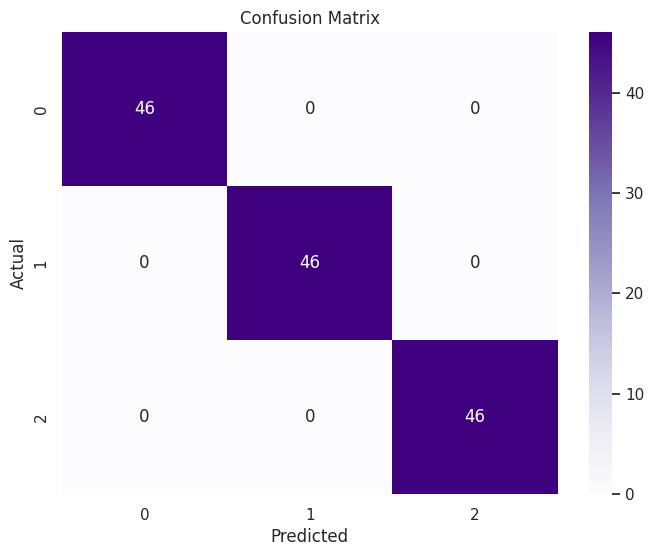

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Evaluate the final model on the test set
best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in final_test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class (Softmax output)
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten lists for metrics calculation
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Calculate metrics for multi-class classification
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')  # Weighted avg for multi-class
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (weighted): {precision:.4f}")
print(f"Recall (weighted): {recall:.4f}")
print(f"F1 Score (weighted): {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', 
            xticklabels=np.unique(all_labels), yticklabels=np.unique(all_labels))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [62]:
pip install captum


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 32.8 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [63]:
from captum.attr import IntegratedGradients

# Create an IntegratedGradients object
ig = IntegratedGradients(best_model)

# Function to summarize attributions (e.g., mean absolute attribution per feature)
def summarize_attributions(attributions):
    return attributions.abs().mean(dim=0).cpu().numpy()

all_attributions = []
# Use a subset of your test data for speed if needed.
for inputs, labels in final_test_loader:
    inputs = inputs.to(device)
    # Define a baseline (e.g., zero tensor of the same shape)
    baseline = torch.zeros_like(inputs).to(device)
    
    # Compute attributions
    attributions, _ = ig.attribute(inputs, baseline, target=labels, return_convergence_delta=True)
    all_attributions.append(attributions)

# Concatenate and summarize attributions across the entire dataset
all_attributions = torch.cat(all_attributions, dim=0)
feature_importance_ig = summarize_attributions(all_attributions)
print("Integrated Gradients Feature Importances:", feature_importance_ig)


Integrated Gradients Feature Importances: [3.57109231 4.83893086 1.79559673]


In [65]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

# Assume 'X' is your original pandas DataFrame used for features.
feature_names = list(X.columns)
num_features = len(feature_names)

def permutation_importance(model, loader, metric_func, device, num_features, n_repeats=5):
    model.eval()
    
    # Compute baseline performance on the loader
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_preds.append(predicted.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    baseline_score = metric_func(all_labels, all_preds)
    
    importances = np.zeros(num_features)
    
    # For each feature, shuffle and measure performance drop
    for feature in range(num_features):
        scores = []
        for _ in range(n_repeats):
            all_preds_perm, all_labels_perm = [], []
            for inputs, labels in loader:
                inputs = inputs.clone().detach()
                # Shuffle values of the current feature across the batch
                idx = torch.randperm(inputs.size(0))
                inputs[:, feature] = inputs[idx, feature]
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                all_preds_perm.append(predicted.cpu().numpy())
                all_labels_perm.append(labels.cpu().numpy())
            all_preds_perm = np.concatenate(all_preds_perm)
            all_labels_perm = np.concatenate(all_labels_perm)
            score = metric_func(all_labels_perm, all_preds_perm)
            scores.append(score)
        # Importance is measured as the drop in performance from the baseline
        importances[feature] = baseline_score - np.mean(scores)
    
    return importances, baseline_score

# Compute importances (using accuracy as the metric)
importances, base_score = permutation_importance(
    best_model, final_test_loader, accuracy_score, device, num_features, n_repeats=10
)
print("Baseline Accuracy:", base_score)

# Create and display a DataFrame with feature importances
df_feature_importance = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

print(df_feature_importance)


Baseline Accuracy: 1.0
                   feature  importance
0   POL DC01-POL DC02_Beta    0.552174
1  POL DC01-POL DC02_Alpha    0.319565
2  POL DC01-POL DC02_Gamma    0.206522
